<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC2</p>
<p style="margin: 0; text-align:right;">2020-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Métodos no supervisados

A lo largo de esta práctica veremos como aplicar distintas técnicas no supervisadas
así como algunas de sus aplicaciones reales:

 - **Clustering con distintas estrategias**: k-means y regla del codo, basadas en densidad y jerárquicas.
 - **Aplicación de reducción de dimensionalidad**: PCA y UMAP.
 - **Aplicación**: segmentación de imágenes de satélite.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Nombre y apellidos: </strong>
</div>

Francisco Javier Melchor González

---

Para ello vamos a necesitar las siguientes librerías:

In [1]:
import random

import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster                   # Algoritmos de clustering.
from sklearn import datasets                  # Crear datasets.
from sklearn import manifold                  # Algoritmos de reduccion de dimensionalidad.
from sklearn import decomposition             # Módulo de reducción de dimensionalidad.
from sklearn.utils import check_random_state  # Gestión de números aleatorios.

# Clustering jerárquico y dendrograma.
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.neighbors import NearestNeighbors

# UMAP para reducción de dimensionalidad.
import umap

# Visualizacion.
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Métodos de *clustering* (4 puntos)

Este ejercicio trata de explorar distintas técnicas de agrupamiento ajustándolas a distintos conjuntos de datos.

El objetivo es doble: entender la influencia de los parámetros en su comportamiento, y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [2]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es a través de los distintos modelos de *clustering* conseguir encontrar las estructuras descritas por las variables *y*.

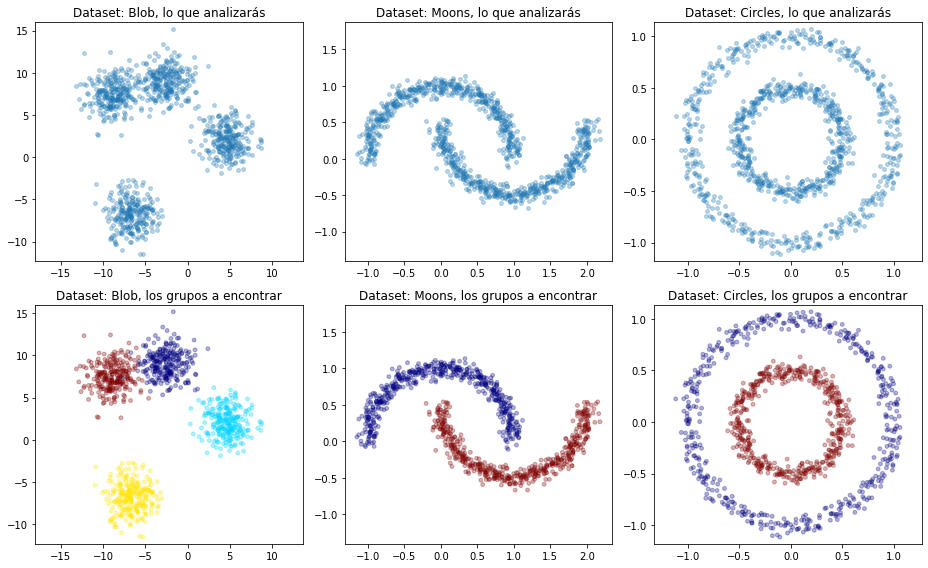

In [3]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [4]:
X, y = X_blobs, y_blobs

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Blobs.
</div>

In [5]:
K = range(1, 10)
sse = []
for k in K:
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

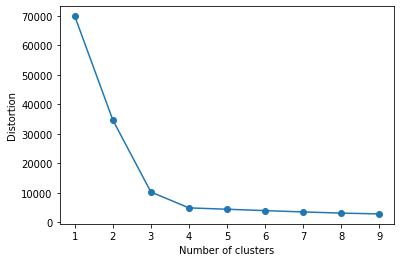

In [6]:
plt.plot(K, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

**En la gráfica mostrada anteriormente, podemos ver que la distorsión**, que viene dada por elvalor SSE descrito anteriormente, **va disminuyendo a medida que aumenta el número de grupos**, esto es debido a que a medida que aumenta el número de grupos a dividir el conjunto total de datos, más compactados se encontrarán los grupos. **Esta gráfica nos indica a través del "codo" de la curva, cual es el número de clústers adecuado**, siendo a partir de dicho punto que representa el "codo" de la curva un número de grupos excesivamente grande para el conjunto de datos y que conllevaría por tanto a un ajuste excesivo en el modelo. **En este caso, el codo de la curva se encuentra en el punto número 3 del eje X, por lo que el número de grupos adecuados para este conjunto de datos es 3.**

**La elección de k podría mejorarse aplicando el método de la silueta para los diferentes valores posibles de K y quedándonos con aquel cuya puntuación obtenida sea mayor**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Blobs.
</div>

In [7]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


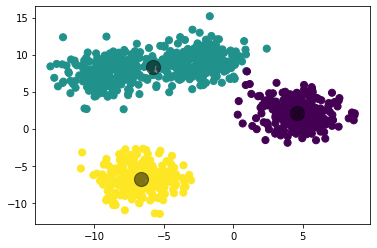

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

**En primer lugar**, lo que **ha sucedido** es **que el valor óptimo de grupos obtenido según la regla del codo**, tal y como se ha visto anteriormente, **es igual a 3, cuando realmente el número real de grupos en los datos es 4.** La razón por la que la regla del codo ha obtenido el valor 3 como número adecuado de grupos es porque los dos primeros grupos del conjunto de datos (que en el gráfico se encuentran representados en la parte superior de este, en un mismo grupo) se encuentran muy unidos entre sí, por lo que un valor de grupos igual a 3 ya permite que los grupos sean compactos entre sí, y por lo tanto parece ser el adecuado, y el valor 4 parece indicar un sobre ajuste, pero realmente en los datos originales el número de grupos es 4.

**Al elegir el valor 3 para la k, que indica el número de grupos, el algoritmo K-Means por tanto ha agrupado en un mismo grupo los dos primeros grupos en uno mismo.**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Moons.
</div>

In [9]:
X, y = X_moons, y_moons

In [10]:
K = range(1, 10)
sse = []
for k in K:
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

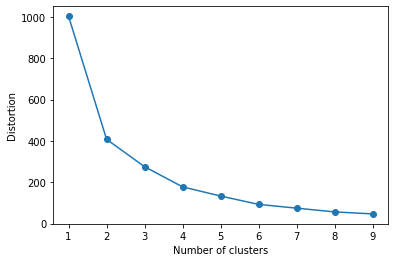

In [11]:
plt.plot(K, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

Tal y como se ha indicado en la visualización anterior de la regla del codo, podemos observar que la distorsión va disminuyendo a medida que aumenta el número de grupos, debido a la explicación dada en la anterior visualización. 

**En este caso, el codo de la gráfica se encuentra en el número 2 del eje X,  por lo que el número de grupos adecuados es igual a 2.**

**La elección de k podría mejorarse aplicando el método de la silueta para los diferentes valores posibles de K y quedándonos con aquel cuya puntuación obtenida sea mayor**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Moons.
</div>

In [12]:
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


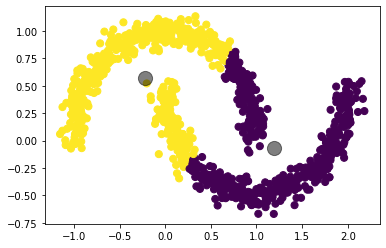

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Lo que **ha sucedido es que, a pesar de que esta vez la regla del codo si ha proporcionado un número de grupos que corresponde con el número de grupos real de los datos**, es decir 2, **estos no han sido agrupados correctamente por el algoritmo K-Means.**

**Los motivos por los que el algoritmo K-Means no ha conseguido agrupar correctamente este conjunto de datos es porque el mismo crea los grupos a través de un centroide asignado para cada grupo indicado a crear y busca los puntos más cercanos al mismo.** 

**En este caso, el dataset Moons forma dos curvas cuyos extremos de cada una de ellas se encuentran muy cercanos al centro de la otra, por lo que los puntos más cercano a los centroides que se encuentran en los extremos de dichas curvas, pertenecen en parte al extremo de la curva donde se encuentra el centroide y al centro de la otra curva, agrupando así de esta forma en cada grupo datos de las dos curvas que son las que representan realmente los grupos formados en los datos originales.**


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Circles.
</div>

In [14]:
X, y = X_circles, y_circles

In [15]:
K = range(1, 10)
sse = []
for k in K:
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

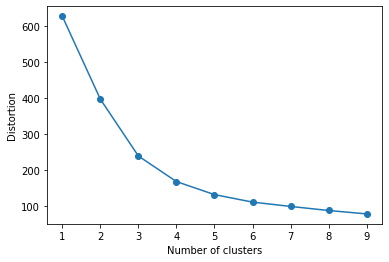

In [16]:
plt.plot(K, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

**En esta gráfica** que permite visualizar como va disminuyendo la distorsión conforme aumenta el número de clusters (debido a la explicación dada en las gráficas anteriores), **podemos ver que el codo de la curva se encuentra en el punto número 3, por lo que según la regla del codo el número de grupos adecuado para este conjunto de datos es 3.**

**La elección de k podría mejorarse aplicando el método de la silueta para los diferentes valores posibles de K y quedándonos con aquel cuya puntuación obtenida sea mayor**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Circles.
</div>

In [17]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


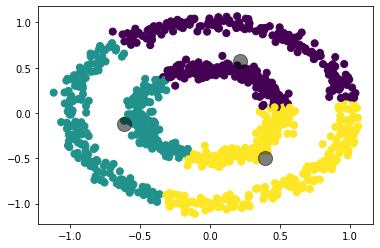

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

**En primer lugar, el número de grupos adecuados obtenidos según la regla del codo no es el correcto, según la regla del codo el número de grupos adecuado es 3 y realmente el número de grupos presentes en los datos son dos, los dos círculos que aparecen en el gráfico anterior**. Al tratarse de dos círculos cuyo centro es el mismo, no es posible asignar un mismo centroide para los dos grupos, por lo que el número de grupos indicado por la regla del codo es igual a 3, porque si dividimos ambos círculos en 3 grupos los centros de los mismos forman un conjunto de grupos compactos. 

De la misma forma, **el algoritmo K-Means a agrupado los datos dividiendo en 3 el conjunto total de datos y obteniendo los puntos más cercanos a los centros, creando así un conjunto de grupos erróneos y que no corresponden con la realidad.**

### 1 b. Algoritmos basados en densidad: DBScan

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) a los datasets anteriores para detectar los grupos subyacentes.

In [19]:
X, y = X_blobs, y_blobs

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

Para estimar un valor óptimo del parámetro *eps*, tal y como se indica en el enlace anterior del algoritmo DBSCAN (https://en.wikipedia.org/wiki/DBSCAN), se puede realizar a través del gráfico "Nearest neighbors", el cual traza la distancia al vecino más cercano, siendo un buen valor para *eps* en el valor que represente un codo en dicha gráfica.

Por ello, a continuación se representa la gráfica "Nearest neighbors", para obtener así el número óptimo para *eps*, según esta regla.

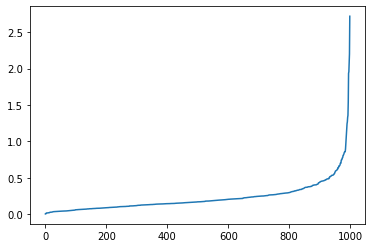

In [20]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Inicialmente, el valor del parámetro *minPts* será 2 debido a que tal y como se indica en el enlace anterior del algoritmo DBSCAN(https://en.wikipedia.org/wiki/DBSCAN), como regla general se puede utilizar el número de dimensiones de los datos, que en este caso son 2.

In [21]:
dbscan = cluster.DBSCAN(eps=0.6, min_samples=2)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


In [22]:
def print_dbscan(labels):
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

Estimated number of clusters: 30
Estimated number of noise points: 45


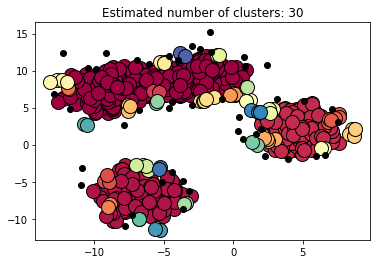

In [23]:
print_dbscan(labels)

In [24]:
dbscan = cluster.DBSCAN(eps=0.6, min_samples=5)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

Estimated number of clusters: 9
Estimated number of noise points: 142


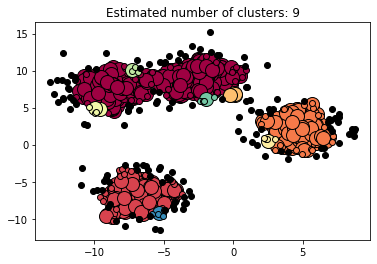

In [25]:
print_dbscan(labels)

In [26]:
dbscan = cluster.DBSCAN(eps=0.6, min_samples=10)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

Estimated number of clusters: 4
Estimated number of noise points: 316


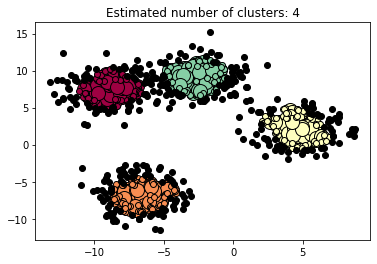

In [27]:
print_dbscan(labels)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Lo que ha sucedido es que **a medida aumentamos el número de puntos requeridos para que una región se considere lo suficientemente densa para el algoritmo DBSCAN, cuyo valor viene dado por el parámetro *minPts*, mas compactos serán los grupos formados.** 

**En este dataset, los dos grupos superiores se encuentran muy unidos entre sí, por lo que es necesario que los grupos sean lo suficientemente compactos para que estos se agrupen correctamente, por lo que el valor del parámetro *minPts* ha tenido que ser aumentado hasta llegar a 10 porque con los valores 2 y 5 no conseguía crear los grupos correctamente**.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

In [28]:
X, y = X_moons, y_moons

Al igual que para el dataset Moons, mostramos la gráfica "Nearest neighbors" para estimar el valor óptimo de *eps* según la misma

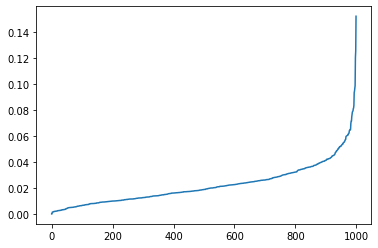

In [29]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [30]:
dbscan = cluster.DBSCAN(eps=0.04, min_samples=2)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 89
Estimated number of noise points: 115


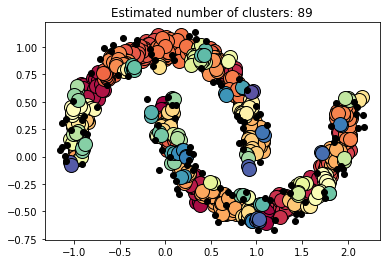

In [31]:
print_dbscan(labels)

In [32]:
dbscan = cluster.DBSCAN(eps=0.04, min_samples=5)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 48
Estimated number of noise points: 356


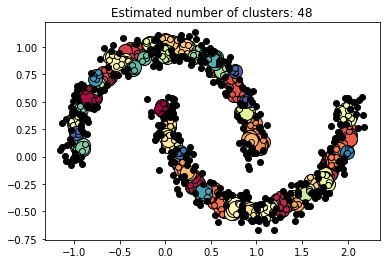

In [33]:
print_dbscan(labels)

In [34]:
dbscan = cluster.DBSCAN(eps=0.06, min_samples=2)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 15
Estimated number of noise points: 33


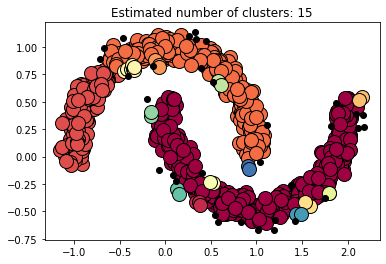

In [35]:
print_dbscan(labels)

In [36]:
dbscan = cluster.DBSCAN(eps=0.06, min_samples=5)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 8
Estimated number of noise points: 78


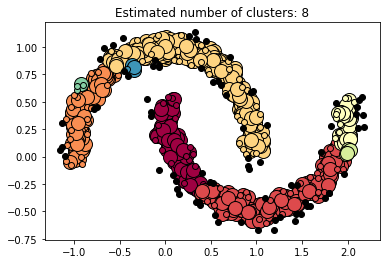

In [37]:
print_dbscan(labels)

In [38]:
dbscan = cluster.DBSCAN(eps=0.1, min_samples=2)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 3
Estimated number of noise points: 3


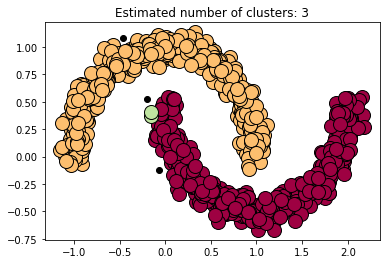

In [39]:
print_dbscan(labels)

In [40]:
dbscan = cluster.DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 2
Estimated number of noise points: 7


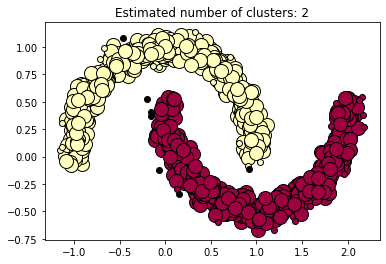

In [41]:
print_dbscan(labels)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

**En este caso, el valor de *eps* estimado a través de la gráfica "Nearest neighbor" no ha sido el correcto y este ha tenido que aumentarse**. El número indicado por esta gráfica en principio era muy pequeño debido a que los dos extremos de las dos curvas que forman este dataset se encuentran muy cercanos al centro de la otra, lo que hace que en se concentren un gran número de puntos en ambos extremos y que la distancia de los puntos necesaria para agrupar sea pequeña, además de que los puntos de este dataset se encuentran repartidos prácticamente a lo largo del plano, por lo que la distancia óptima estimada tiende a ser menor de la adecuada realmente.

**A medida que se ha ido aumentando la distancia a la que un punto se considera alcanzable como máximo el algoritmo ha obtenido mejores resultados, hasta llegar a una distancia de 0.1 que ha resultado ser la óptima. El valor de *minPts* también ha tenido que aumentarse hasta el valor 5 debido a que existen algunos puntos un poco más alejados de los datos y si no se aumenta el número mínimo de puntos para considerar un grupo denso, no consigue agrupar correctamente.**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

In [42]:
X, y = X_circles, y_circles

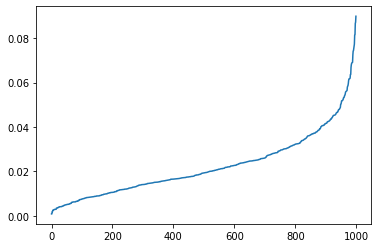

In [43]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [44]:
dbscan = cluster.DBSCAN(eps=0.04, min_samples=2)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 98
Estimated number of noise points: 116


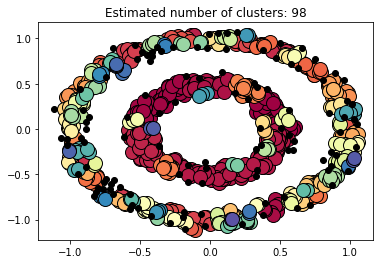

In [45]:
print_dbscan(labels)

In [46]:
dbscan = cluster.DBSCAN(eps=0.04, min_samples=5)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 41
Estimated number of noise points: 428


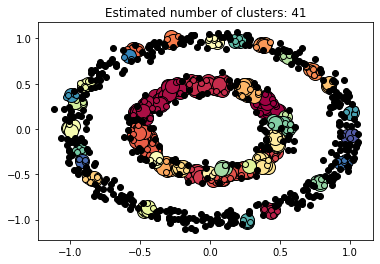

In [47]:
print_dbscan(labels)

In [48]:
dbscan = cluster.DBSCAN(eps=0.04, min_samples=10)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 10
Estimated number of noise points: 884


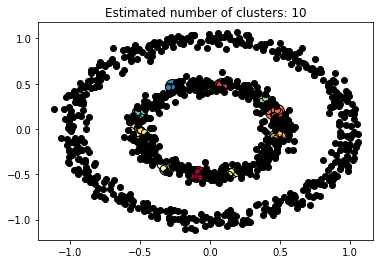

In [49]:
print_dbscan(labels)

In [50]:
dbscan = cluster.DBSCAN(eps=0.1, min_samples=2)
dbscan.fit(X)
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


Estimated number of clusters: 2
Estimated number of noise points: 0


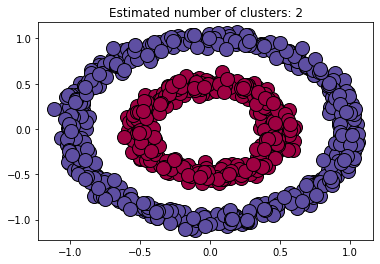

In [51]:
print_dbscan(labels)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

**Al igual que para el dataset Moons, el valor de *eps* estimado principalmente era muy pequeño, debido a que los puntos se encuentran repartidos a lo largo del plano y a simple vista puede parecer que los grupos son más y que por tanto la distancia máxima para considerar a un vecino alcanzable estimada es más pequeña.** 

**Una vez que se ha aumentado el valor de *eps* al valor 0.1, el algoritmos DBSCAN ha conseguido agrupar los datos correctamente sin tener puntos inalcanzables**, ya que los puntos de cada grupo se encuentran cercanos entre sí y no se encuentran muy alejados de los grupos.

### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [52]:
from sklearn.cluster import AgglomerativeClustering


In [53]:
def print_dendogram(linked):
    plt.figure(figsize=(10, 7))
    plt.title("Customer Dendograms")
    dend = dendrogram(linked, no_labels=True)

In [54]:
X, y = X_blobs, y_blobs

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong><br>

prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [55]:
linked = linkage(X, 'single')

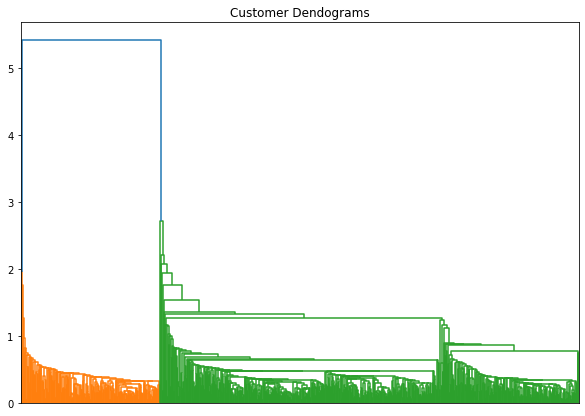

In [56]:
print_dendogram(linked)

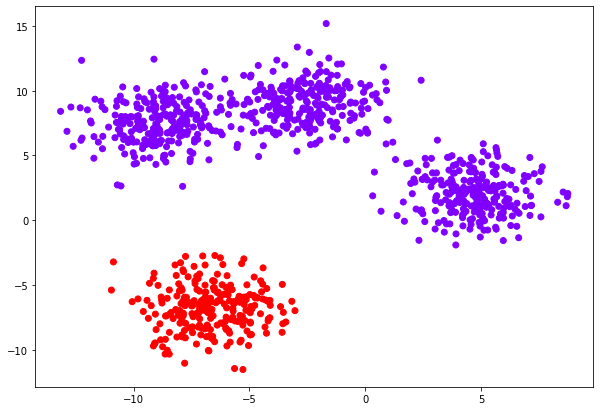

In [57]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='single')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [58]:
linked = linkage(X, 'complete')

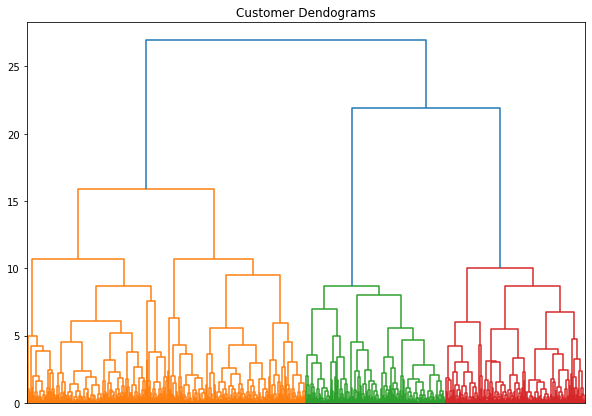

In [59]:
print_dendogram(linked)

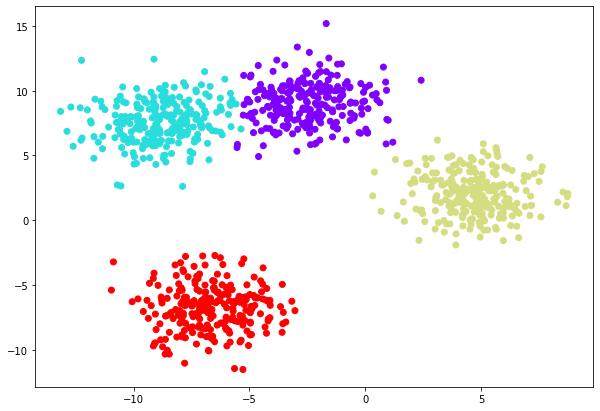

In [60]:

aglom_cluster = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage='complete')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [61]:
linked = linkage(X, 'average')

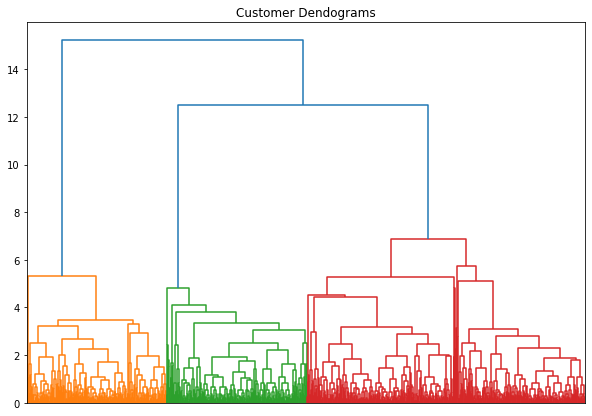

In [62]:
print_dendogram(linked)

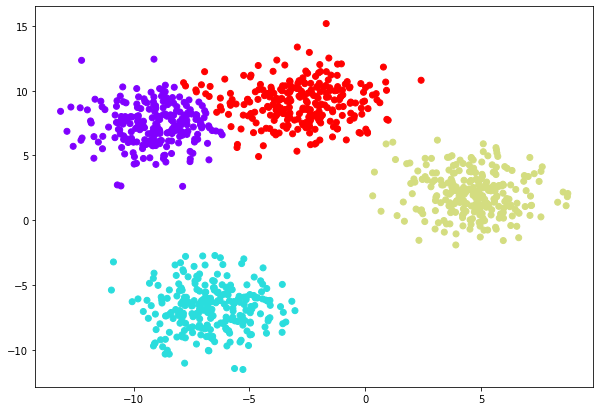

In [63]:

aglom_cluster = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage='average')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [64]:
linked = linkage(X, 'ward')

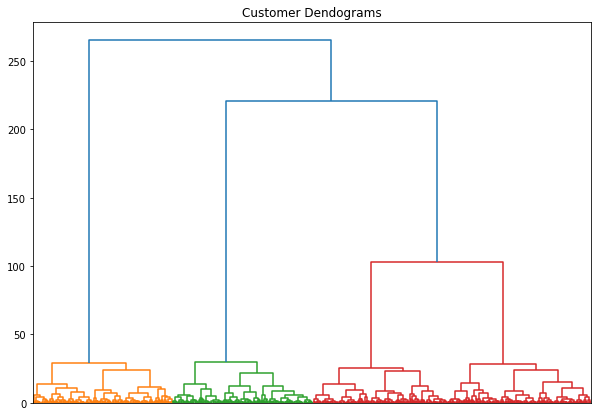

In [65]:
print_dendogram(linked)

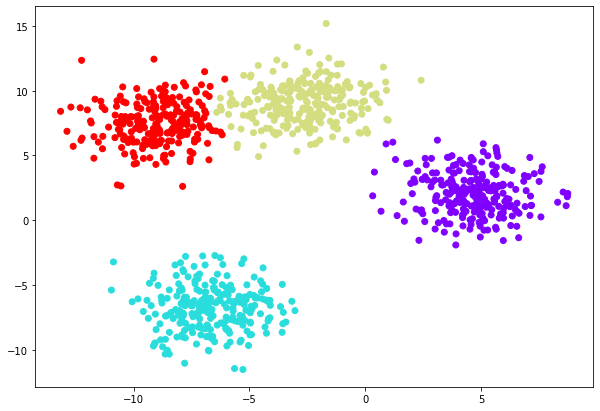

In [66]:

aglom_cluster = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage='ward')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

**Interpretando los dendogramas obtenidos por los diferentes criterios de enlace probados, single, complete, average y ward, podemos ver que el único que se ha comportado de una forma incorrecta ha sido el criterio del enlace simple o single, pues ha creado dos grupos únicamente, cuando realmente hay 4.** Ha juntado los dos grupos de puntos superiores junto con el grupo de puntos de la izquierda porque algunos puntos de dichos grupos se encuentran muy juntos entre sí y el criterio de enlace simple agrupa por la distancia mínima que existe entre los puntos de cada grupo. Al tener puntos tan juntos estos grupos, tiende a agruparlos en uno mismo por el criterio de enlace, ya que la distancia es muy corta en los extremos.

**Los dendogramas restantes de los otros criterios de enlace indica que han conseguido encontrar los 4 grupos presentes en los datos correctamente,** ya que su criterio de enlace no es por la distancia mínima existente entre los puntos que forman cada grupo como en el enlace simple. **Dentro de estos, el que ha conseguido agrupar de una mejor forma, según el dendograma mostrado, es el criterio de enlace Ward,** que en primer lugar crea 4 grupos perfectamente separados unos de otros. **Esto es debido a que el criterio de este enlace no es por la distancia entre puntos sino que agrupa por la varianza mínima del clúster, que es una medida de agrupación de distancias al punto medio, lo que permite realizar una mejor estimación**




<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong><br>

prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [67]:
X, y = X_moons, y_moons

In [68]:
linked = linkage(X, 'single')

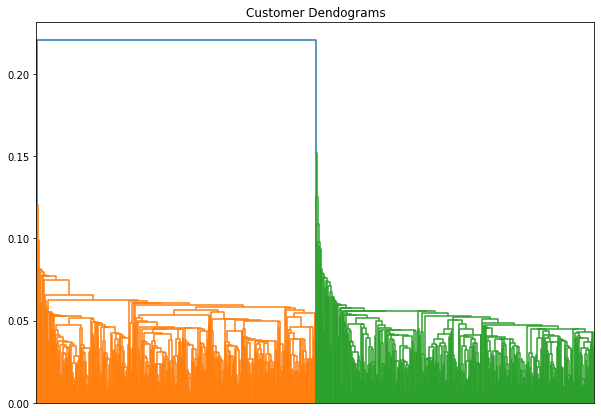

In [69]:
print_dendogram(linked)

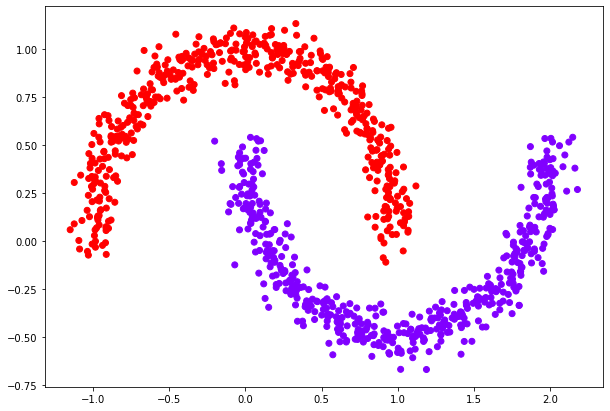

In [70]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='single')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [71]:
linked = linkage(X, 'complete')

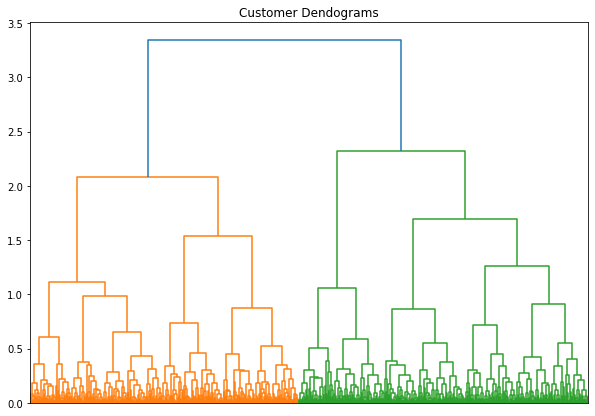

In [72]:
print_dendogram(linked)

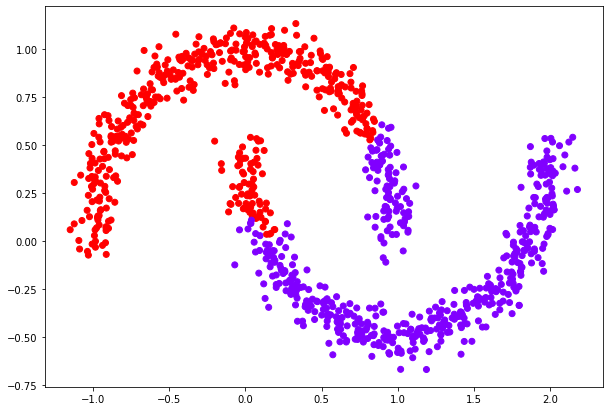

In [73]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='complete')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [74]:
linked = linkage(X, 'average')

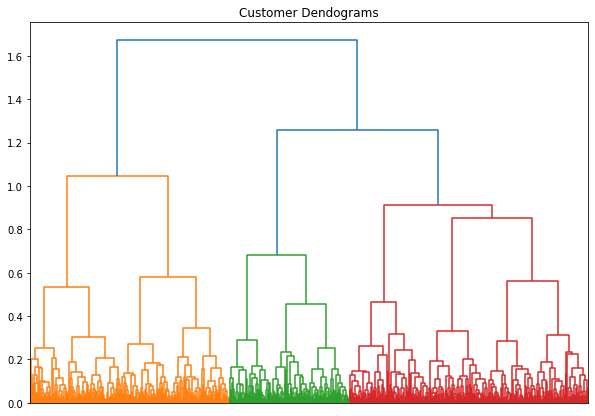

In [75]:
print_dendogram(linked)

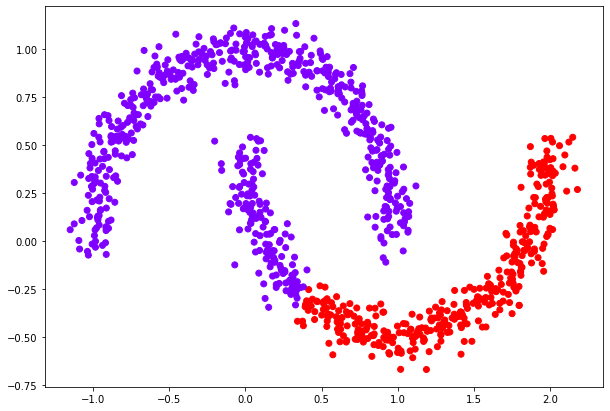

In [76]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='average')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [77]:
linked = linkage(X, 'ward')

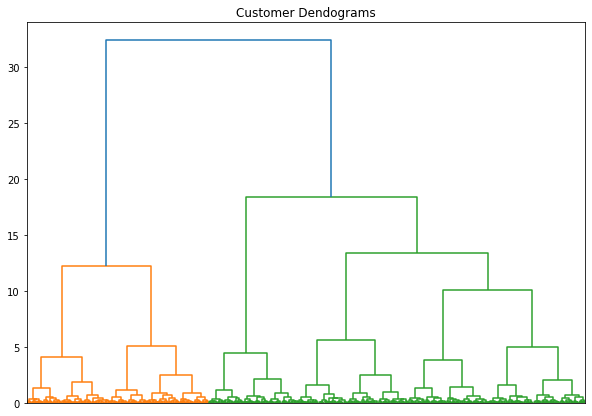

In [78]:
print_dendogram(linked)

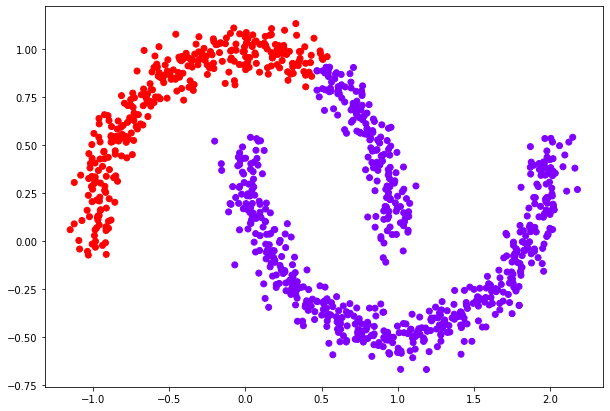

In [79]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='ward')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

**En el caso del dataset Moons**, interpretando los dendogramas obtenidos por los diferentes criterios de enlace, **podemos ver que el que se ha comportado mejor es el criterio de enlace simple. Esto es debido a que este agrupa los datos utilizando como criterio la distancia mínima de los puntos de cada clúster que inicialmente se encuentran separados. Como la distribución de los puntos de los grupos de este dataset es más compacta logra agrupar correctamente los datos utilizando la distancia mínima entre los puntos.**

**Sin embargo, utilizando como criterio la distancia máxima (complete), la media (average) o la varianza (ward) los grupos están más separados lo que indica que no se están creando correctamente, porque los puntos de ambos grupos originales realmente están muy unidos**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong><br>

prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [80]:
X, y = X_circles, y_circles

In [81]:
linked = linkage(X, 'single')

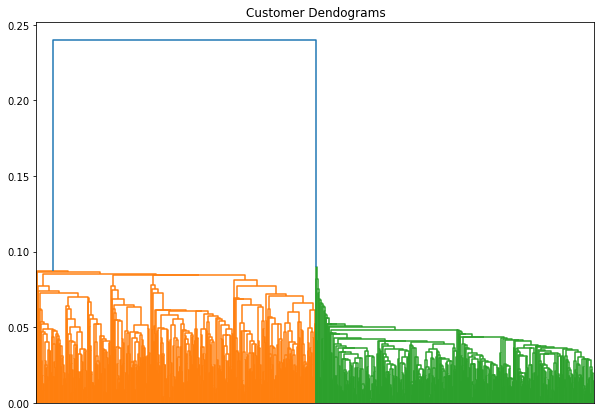

In [82]:
print_dendogram(linked)

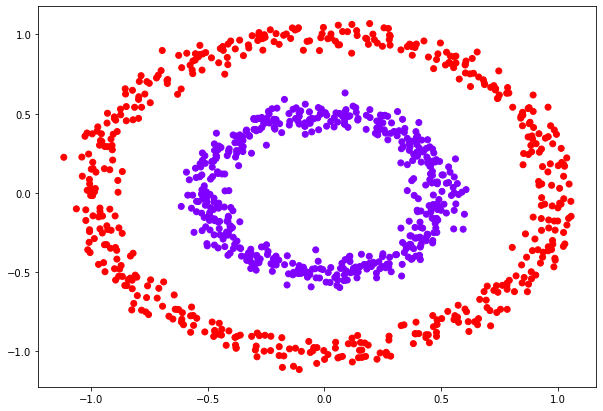

In [83]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='single')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [84]:
linked = linkage(X, 'complete')

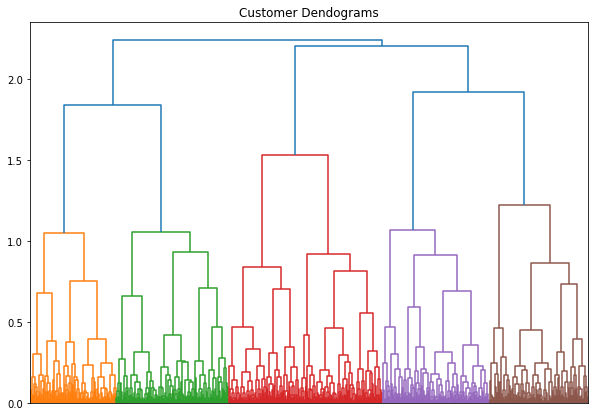

In [85]:
print_dendogram(linked)

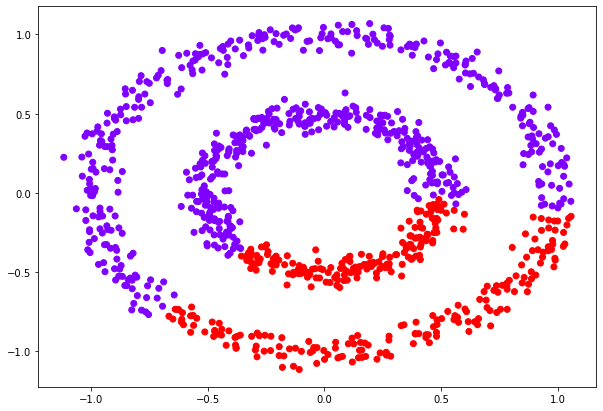

In [86]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='complete')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [87]:
linked = linkage(X, 'average')

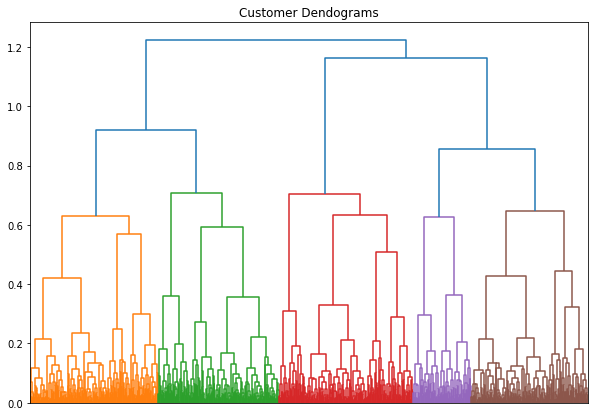

In [88]:
print_dendogram(linked)

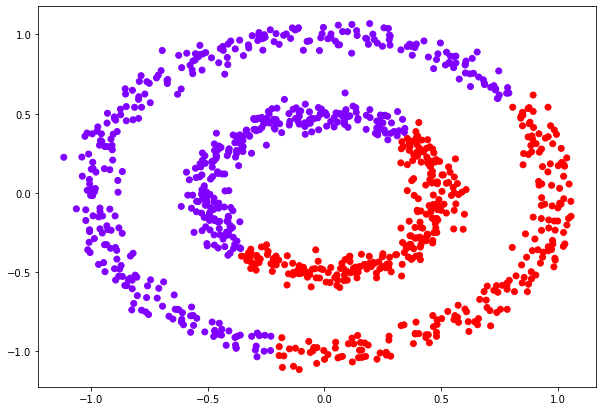

In [89]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='average')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

In [90]:
linked = linkage(X, 'ward')

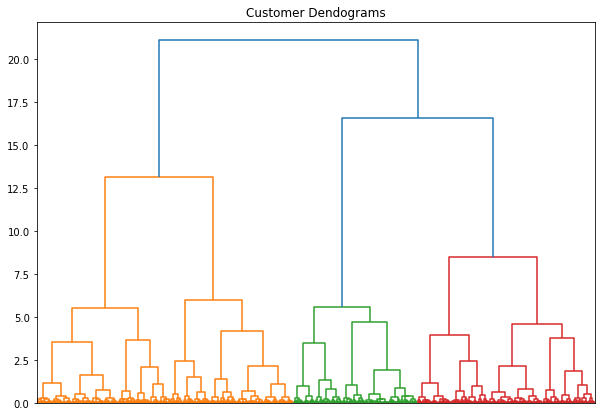

In [91]:
print_dendogram(linked)

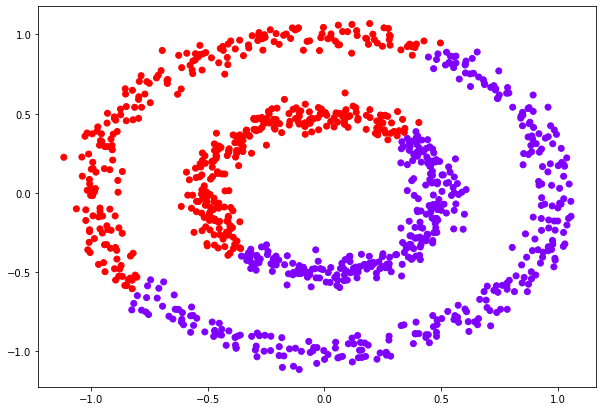

In [92]:

aglom_cluster = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='ward')
aglom_cluster.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=aglom_cluster.labels_, cmap='rainbow')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

**De forma similar a lo ocurrido con el dataset Moons, en este dataset el criterio que se comporta mejor, según se puede interpretar en los dendogramas mostrados, es el Single o criterio Simple.**

**Este criterio logra crear dos grupos de puntos muy compactos y por tanto unidos entre sí porque utiliza como criterio la distancia mínima entre puntos para agrupar un clúster con otro. Sin embargo, los otros criterios, crean grupos con puntos más separados entre sí, lo que indica que no están agrupando correctamente, ya que los grupos existentes en los datos son muy compactos y se encuentran perfectamente separados los puntos de un grupo al de otro, tal y como ocurre al aplicar el criterio simple.**

## 2. Aplicación de reducción de dimensionalidad (2 puntos)

Es posible aplicar una amplia variedad de algoritmos para la reducción de dimensionalidad. Para ello se empleará el dataset MNIST compuesto de miles de dígitos manuscritos del 0 al 9. Donde cada imagen se compone de 784 píxeles (imágenes de 28 x 28), por lo que se parte de un número alto de dimensiones.

In [93]:
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=5000, test_size=5000)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

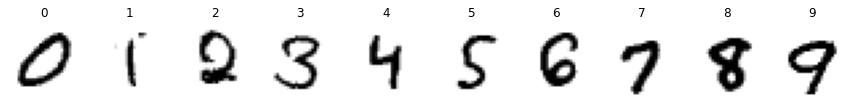

In [94]:
fig, axis = plt.subplots(1, 10, figsize=(12, 6))
for i, ax in zip(range(10), axis):
    ax.imshow(X_train[y_train == i][0].reshape(28, 28), cmap='gray_r')
    ax.set_title(str(i))
    ax.axis('off')
plt.tight_layout()

In [95]:
X_train.shape # 5000 muestras con 784 valores (pixeles)

(5000, 784)

Si cada algoritmo obtiene resultados distintos a la hora de reducir la dimensionalidad, ¿qué representación es más fiel a la distribución original?

Antes de reducir las 784 dimensiones originales de cada muestra a 2 para poder visualizarlas en 2 dimensiones, es muy útil conocer, o al menos intuir, la estructura en alta dimensionalidad de los datos.

Para ello se puede hacer uso del dendrograma como heurística para conocer la disposición original de los datos y comprobar si la proyección es similar a lo mostrado por el dendrograma.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> realiza un dendrograma con las muestras de X_train (o un subconjunto de ellas para acelerar el proceso) usando el método ward. <br>
    Como consejo, la función dendrogram tiene un parámetro llamado no_labels que evita mostrar etiquetas para cada muestra y puesto a True evita mostrarlas, cargando la imagen más rápido.
</div>

In [96]:
linked = linkage(X_train, 'ward')

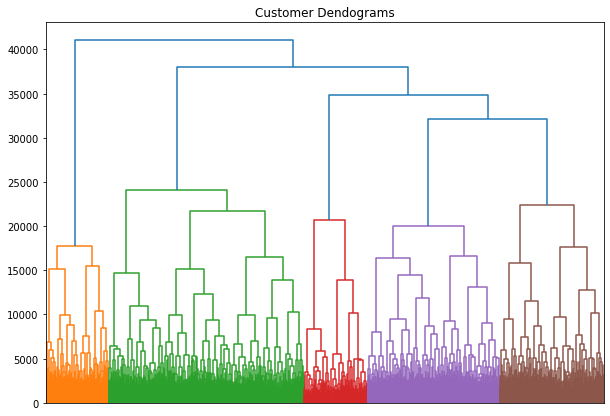

In [97]:
print_dendogram(linked)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> aprender una proyección a 2 dimensiones de las muestras de X_train con PCA y proyectar el conjunto X_test a dos dimensiones. Después visualizarlo en un scatter plot.<br>
    Puedes utilizar las etiquetas de y_test, el parámetro label (en la llamada a scatter) y la función legend en la visualización para saber la clase correspondiente a cada punto e interpretar el resultado de la reducción de dimensionalidad.
</div>

In [98]:
from sklearn.decomposition import PCA


In [99]:
import seaborn as sns

In [100]:
pca = PCA(n_components=2)
mnist_pca = pca.fit(X_train)

In [101]:
X_test_pca = mnist_pca.transform(X_test)

In [102]:
X_test_pca

array([[-166.67403324, -432.04182778],
       [ 246.6745588 ,  823.88423585],
       [  56.22460478,  491.95351764],
       ...,
       [-425.84606679, -662.08110735],
       [-468.70179513, -146.29532948],
       [-400.64084771, -123.75641035]])

In [103]:
X_test_pca = pd.DataFrame(data = X_test_pca, columns=['independent_feature_1', 'independent_feature_2'])
X_test_pca['class'] = y_test

<AxesSubplot:xlabel='independent_feature_1', ylabel='independent_feature_2'>

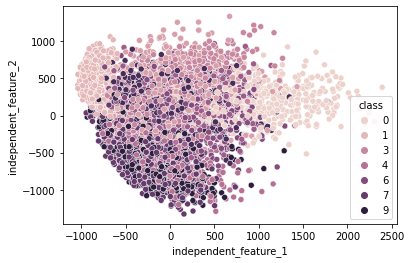

In [104]:
sns.scatterplot(data=X_test_pca, x="independent_feature_1", y="independent_feature_2", hue="class")


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué se puede intuir de la proyección? ¿Se parece a lo representado en el dendrograma?
</div>

**Según el dendograma mostrado anteriormente, existen 6 grupos presentes en los datos, por lo que estos deberían verse reflejados también en la proyección anterior si el algoritmo de reducción de dimensionalidad ha funcionado correctamente para este conjunto de datos, sin embargo, tal y como podemos observar, no se pueden apreciar 6 grupos aparentemente presentes en la proyección anterior.**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> aprender una proyección a 2 dimensiones de las muestras de X_train con UMAP y proyectar el conjunto X_test a dos dimensiones. Después visualizarlo en un scatter plot.<br>
    Puedes utilizar las etiquetas de y_test, el parámetro label (en la llamada a scatter) y la función legend en la visualización para saber la clase correspondiente a cada punto e interpretar el resultado de la reducción de dimensionalidad.
</div>

In [105]:
mnist_umap = umap.UMAP().fit(X_train)

In [106]:
X_test_umap = mnist_umap.transform(X_test)

In [107]:
X_test_umap

array([[ 7.4714036 , -1.0330065 ],
       [ 3.2828798 ,  4.497751  ],
       [ 5.46953   ,  3.846554  ],
       ...,
       [ 8.45913   ,  0.15660043],
       [ 7.6327147 ,  2.1756275 ],
       [ 8.844976  ,  4.567816  ]], dtype=float32)

In [108]:
X_test_umap = pd.DataFrame(data = X_test_umap, columns=['independent_feature_1', 'independent_feature_2'])
X_test_umap['class'] = y_test

<AxesSubplot:xlabel='independent_feature_1', ylabel='independent_feature_2'>

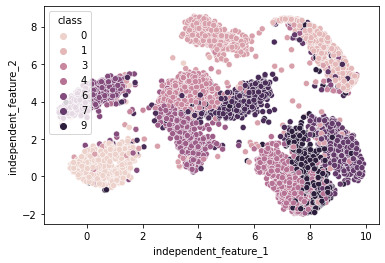

In [109]:
sns.scatterplot(data=X_test_umap, x="independent_feature_1", y="independent_feature_2", hue="class")


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué se puede intuir de la proyección? ¿Se parece a lo representado en el dendrograma?
</div>

**En la proyección anterior que muestra la representación de los datos obtenido tras aplicar la reducción de dimensionalidad UMAP, podemos ver que si que se aprecia la presencia de los 6 grupos extraídos por el dendograma, por lo que si que se parece a lo mostrado en el dendograma.**

## 3. Aplicación: segmentación de imágenes de satélite (4 puntos)

Hoy en día los mapas de carreteras, geológicos, agrícolas... se confeccionan con imágenes satélites. Para ello es necesario interpretar esas imágenes buscando en ellas los elementos de interés. Dado el volumen actual de imágenes que generan los satélites, hacer la segmentación de forma manual no es una opción y por ello hay tantos esfuerzos en su automatización.

Asumiendo que el espacio de píxeles tiene cierta estructura y que los distintos elementos a buscar son grupos en ella. Es razonable pensar que una estrategia de clustering (entre muchas otras) puede hallar estos grupos en dicha estructura, permitiendo automatizar la segmentación de imágenes.

Partimos de una imagen con diversos tipos de vegetación y caminos:

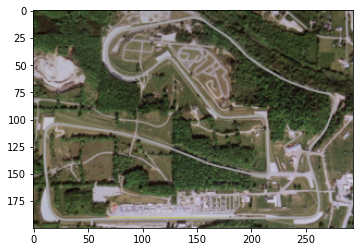

In [110]:
from skimage import io, transform

photo = transform.resize(
    io.imread('https://lh3.googleusercontent.com/-kHq0XyQh3b8/TYFk1h0r2-I/AAAAAAAAAJA/i3rdSELDqxM/s1600/road_america_base.jpg'),
    (200, 294), mode='edge')
plt.imshow(photo)
X = photo.reshape(-1, 3)

Al igual que en el apartado anterior, se ha dado un formato de array a la imagen con tantas filas como píxeles y 3 columnas (una por canal).

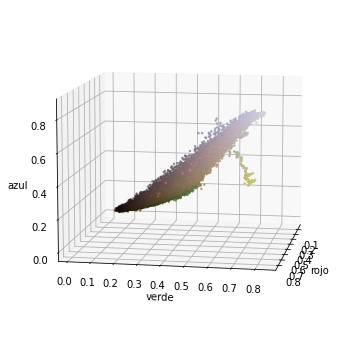

In [111]:
from mpl_toolkits.mplot3d import Axes3D

def plot_pixels_3d(data: "np.array[float]", elev: int = None, azim: int = None) -> None:
    """Visualiza pixeles en un scatter plot 3d (una por canal) con su color correspondiente.
    
    Args:
        data: np.array (puntos, 3)
        elev: int
            angulo de eleveacion en el plano z.
        azim: int
            angulo acimut en el plano x, y.
    """
    assert data.shape[1] == 3, 'Se esperaba un array bidimensional con 3 columnas: (rojo, verde y azul)'
    ax = plt.figure(figsize=(8, 6)).add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], s=2, c=data)
    ax.set_xlabel('rojo')
    ax.set_ylabel('verde')
    ax.set_zlabel('azul')
    ax.view_init(elev, azim)
    plt.show()

plot_pixels_3d(X, 10, 10)

En la visualización anterior se ha representado cada píxel con su color, donde sus coordenadas en los 3 colores oscilan entre 0 (carece de esa componente) y 1. Podemos comprobar como los píxeles en coordenadas (1, 1, 1) son píxeles blancos y los situados en (0, 0, 0) son píxeles negros.

Visualizando en 3 dimensiones los píxeles de la imagen vemos que en este caso no están tan diferenciados los grupos. Pero sí que los píxeles más claros pertenecen a la zona de caminos y los más oscuros al área de vegetación.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> aplica una técnica de clustering para separar los caminos de la vegetación y visualiza tanto la imagen original como la resultante tras aplicar la segmentación para comparar el resultado. ¿Qué algoritmo has elegido? ¿Por qué?
</div>

In [112]:
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


In [113]:
X_df = pd.DataFrame(X)
X_df['cluster'] = y_kmeans

In [114]:
def plot_cluster_3d(df,elev: int = None, azim: int = None):
    fig = plt.figure()
    ax = plt.figure(figsize=(8, 6)).add_subplot(111, projection='3d')
    for c in df.cluster.unique():
        ax.scatter(df[df['cluster']==c][0],df[df['cluster']==c][1],df[df['cluster']==c][2],s=2,label=c)
    ax.set_xlabel('rojo')
    ax.set_ylabel('verde')
    ax.set_zlabel('azul')
    ax.legend()
    ax.view_init(elev, azim)

<Figure size 432x288 with 0 Axes>

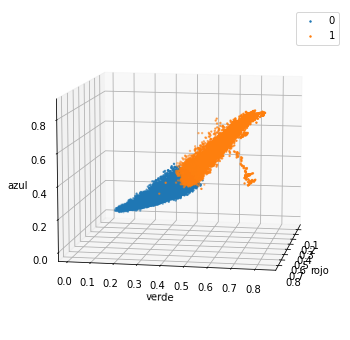

In [115]:
plot_cluster_3d(X_df, 10, 10)

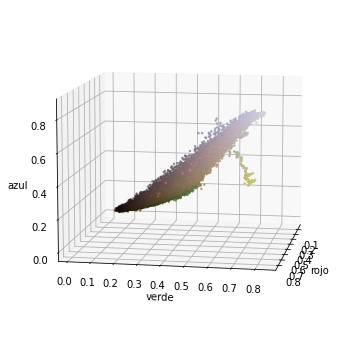

In [116]:
plot_pixels_3d(X, 10, 10)

In [117]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
img_segm = centroids[labels]
img_segm = img_segm.reshape(photo.shape)

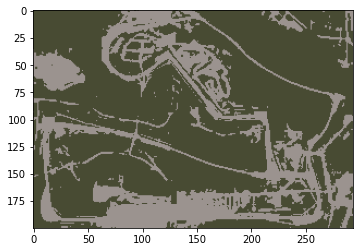

In [118]:
plt.imshow(img_segm)


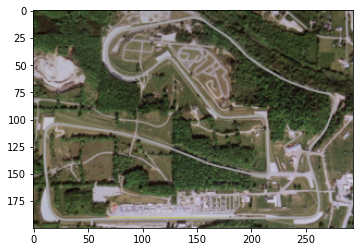

In [119]:
plt.imshow(photo)


**El algoritmo elegido ha sido el algoritmo K-Means, debido a que tal y como se encuentran distribuidos los colores, puede funcionar correctamente según el funcionamiento del mismo, pues se encuentran los más oscuros, que representan la vegetación a un lado y los más claros a otro, siendo por tanto sencillo para el algoritmo K-Means separar los dos grupos a través de un centroide situado en el centro de los puntos representados por los colores oscuros y otro en el cnetro de los puntos que representan colores claros.**

**Otros algoritmos como DBSCAN o el el clustering jerárquico, podrían dar también buenos resultados, pero tardarían mucho más en converger debido a la complejidad y a la gran cantidad de puntos de la imagen mostrada.**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> vuelve a aplicarlo buscando 3 grupos de píxeles.
</div>

In [120]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


In [121]:
X_df = pd.DataFrame(X)
X_df['cluster'] = y_kmeans

<Figure size 432x288 with 0 Axes>

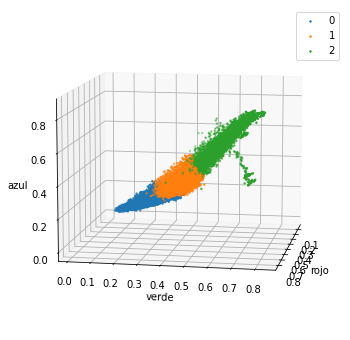

In [122]:
plot_cluster_3d(X_df, 10, 10)

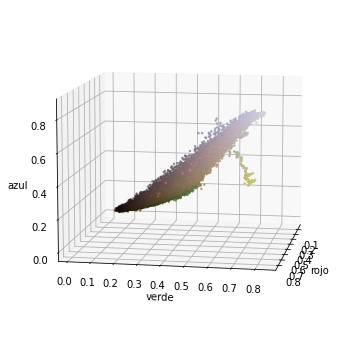

In [123]:
plot_pixels_3d(X, 10, 10)

In [124]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
img_segm = centroids[labels]
img_segm = img_segm.reshape(photo.shape)

In [125]:
labels

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

In [126]:
 centroids[labels]

array([[0.21168269, 0.23897076, 0.14894567],
       [0.21168269, 0.23897076, 0.14894567],
       [0.21168269, 0.23897076, 0.14894567],
       ...,
       [0.21168269, 0.23897076, 0.14894567],
       [0.21168269, 0.23897076, 0.14894567],
       [0.42084955, 0.4012157 , 0.31304228]])

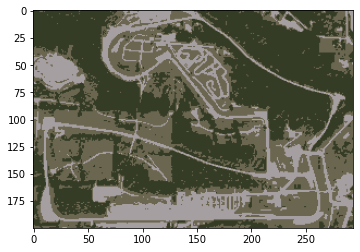

In [127]:
plt.imshow(img_segm)


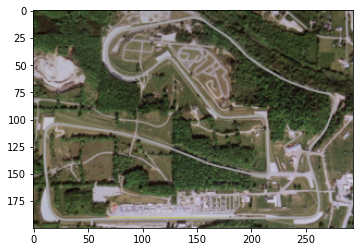

In [128]:
plt.imshow(photo)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué region representa cada uno de ellos?
</div>

**Las regiones que representan son: Por un lado los caminos, que son los colores más claros (blanco), por otro lado los senderos que se encuentran al lado de los caminos, que representa un color algo más oscuro que los caminos pero no tanto como la vegetación y por último la vegetación en otro grupo porque representa los colores más oscuros de la imagen**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> el último paso consiste en aplicar el clustering y separar los caminos del fondo, poniendo este último en negro (rellenar con 0 los valores de los píxeles del fondo). Quedando segmentandos de manera automática los caminos del resto de elementos de la fotografía.
</div>

In [129]:
from more_itertools import zip_equal as izip


In [130]:
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


In [131]:
y_kmeans

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [132]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
img_segm = centroids[labels]
img_segm = img_segm.reshape(photo.shape)

In [133]:
X_df = pd.DataFrame(X)
X_df['cluster'] = y_kmeans

In [134]:
X_df['cluster'].value_counts()

0    41313
1    17487
Name: cluster, dtype: int64

In [135]:
def function(row):
    if row.cluster == 0:
        return 0,0,0
    else:
        return 198,183,172

In [136]:
X_df[0], X_df[1], X_df[2] = izip(*X_df.apply(lambda func: function(func), axis=1))

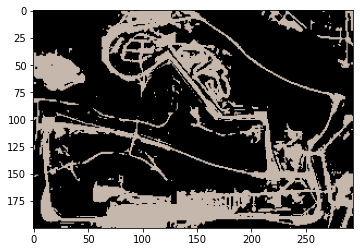

In [137]:
plt.imshow(X_df[[0,1,2]].to_numpy().reshape(photo.shape))
